# DL Major Project -  Generation of Music using Variable AutoEncoder and Generator. 

**Brief Summary:** In this project we make a Variational Encoder whose encoding distributions are regularised. We pass the input. The input is fed to an encoder which compresses music to say a representation z. Then a decoder recreates the music. The output and input are compared and the error is backpropagated. The generative process is to sample a point from the latent space and make it go through the decoder to get a new data. 

**Key Contributions**

*   Aditya Vidyadhar Kamath -  Noise removal/Generated Auto eNcoder - 2020H1030073G
*   Debanjan Chattopadhyay - Noise removal/Modification of VAE - 2020H1030042G
*   Shashwat Kattiyar - Data Preprocessing - 2020H1030057G
*   Shikhar Vashishtha - Result Analysis - 2020H1030050G

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! pip install kaggle

# DataSet Linking with Kaggle

1: **Download a kaggle.json file** (by going into kaggle.com website. CLick account and then click create new API token. Download the kaggle.json file). 
2: Copy the file after mounting the drive into your drive. 

In [ ]:
! mkdir ~/.kaggle #Kaggle dir creation

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/ #copy kaggle.json file

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json #Change Permission

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification #Kaggle Dataset

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip gtzan-dataset-music-genre-classification

Archive:  gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow-addons 
#install required dependencies

# Imports and Dataset Loading

In our train and test data we chose only 24 samples as we observed certain representational errors within the genere Jazz as we were preprocessing. 

Even indices are used for training and odd indices are used for testing

In [ ]:
import os
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import librosa
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from IPython import display
import IPython.display as ipd
import imageio
from IPython.display import clear_output
import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE
import random

In [ ]:
epochs = 25
BASE_PATH = '/content/Data/genres_original'
train_size = 30000
test_size = 10000
BATCH_SIZE = 10
latent_dim = 2 # We will use a 2D lattice space dimensionality
num_examples_to_generate = 10

In [ ]:
def LoadDataset(name_of_genere):
    #print(music_list)
    #We split the dataset into even indices and odd for test and train stored in lists i and j respectively.
    i = []
    j = []
    for k in range(0,49):
      if k%2 == 0:
        i.append(k)
      else:
        j.append(k)
    #get the music list
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+name_of_genere)))
    #dividing into test and train. We use 24 and 24 each. This is because we spotted errors in some of the jazz audio file representation
    train_music = list(music_list[[99,10,66,76,41,0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41 
    test_music = list(music_list[[65,32,53,22,19,80,89,4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89, 
    Train_TrackSet = [(BASE_PATH)+'/'+name_of_genere+'/%s'%(x) for x in train_music]
    Test_TrackSet = [(BASE_PATH)+'/'+name_of_genere+'/%s'%(x) for x in test_music]

    return Train_TrackSet, Test_TrackSet

In [ ]:
Train_data, Test_data = LoadDataset('jazz')

def load(file_):
    data_, sampling_rate = librosa.load(file_,offset=0.0, sr=3000, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])



# Sample input before generating output

These 2 cells show a sample input music from the test dataset. This is how the the output should look like after training in an ideal case. 

The next cell indicates the waveforms of the music

In [ ]:
sample = Test_data[2]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

#this cell shows a sample input. Ideally after generation this is how the output should look like

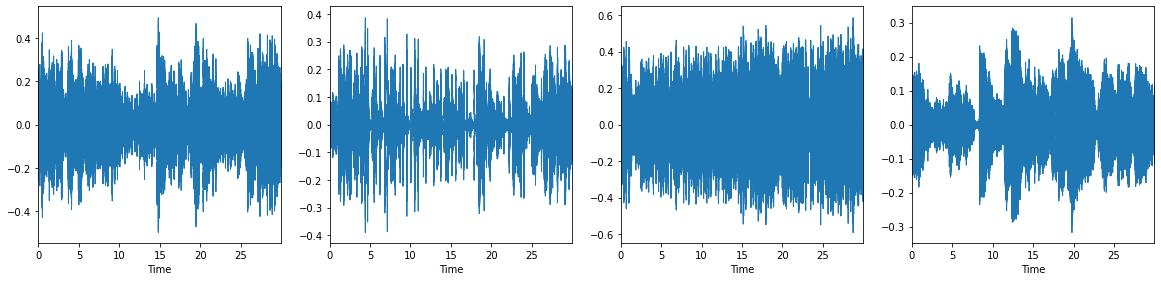

In [ ]:
plt.figure(figsize=(20,20))

import librosa.display
for i in range(0,4):
    plt.subplot(4, 4, i + 1)
    wave_form = load(Test_data[i])
    librosa.display.waveplot(wave_form[0], sr=3000)  

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Train_data))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Test_data))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

# Model Building

In this work we referred the work of **Jukebox: A Generative Model for Music**. All layers have been configured as per the research paper. The input sampling rate is 3000. The batchsize is 10 and train_size is 30,000. The test_size is 10,000. 

The difference between a normal encoder and an autoencoder is that instead of encoding an input as a single point, we encode it as a distribution over the latent space. first, the input is encoded as distribution over the 2D space
Then a point from the 2D space is sample. 
After that the sampled point is decoded and the reconstruction error can be computed. This is where th noise is which is why there is error in output ie. noise due to compression loss. 
finally, the reconstruction error is backpropagated through the network

Audio usually has spatial relationship which is why we went with CNN. 

Specifications and reasons for selection of layers, activation function as mentioned in comments. 

Picture Credits: TowardsDataScience.com

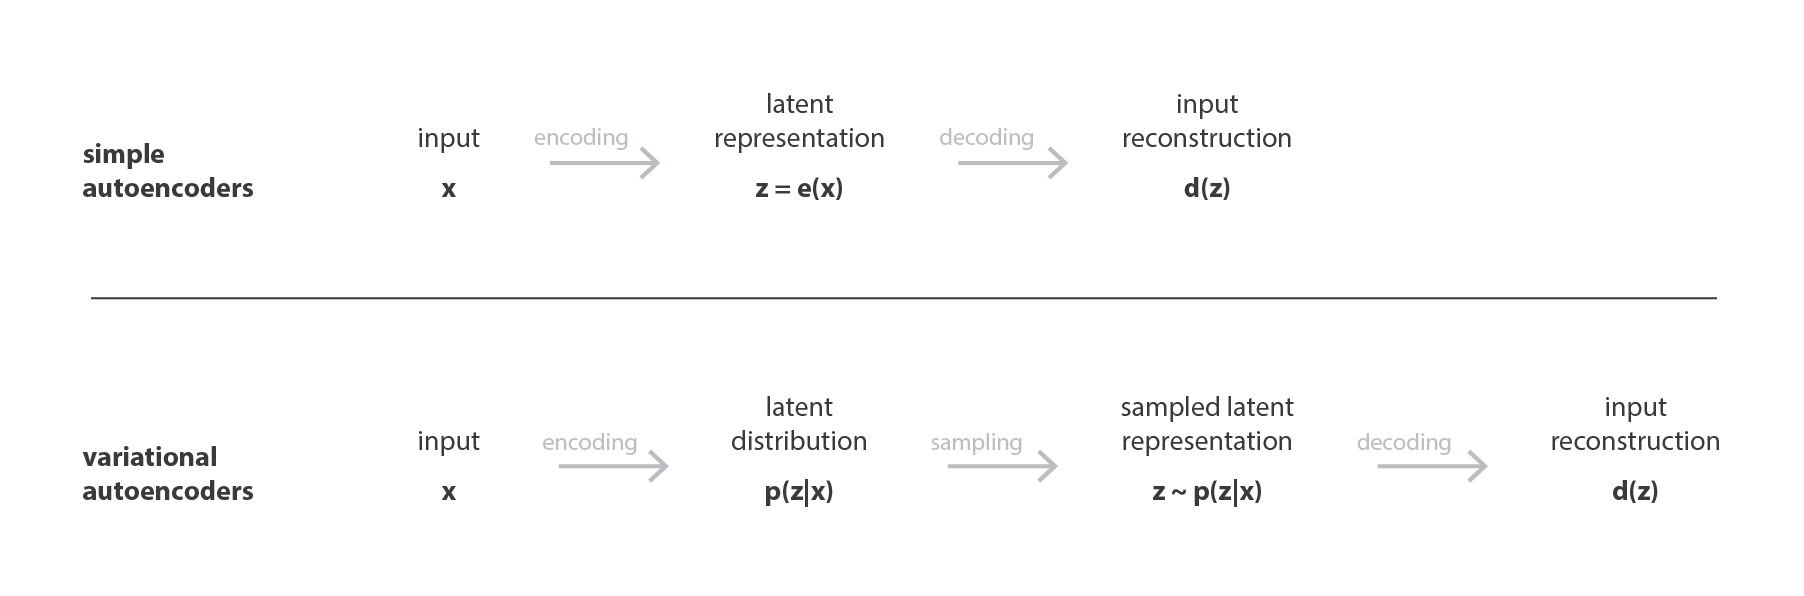

In [ ]:
class Resnet1DBlock(tf.keras.Model): #A traditional Residual network with a encode layer and a decode layer
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name=str(random.randint(5, 1000)))
    
        if type=='encode': #2 layers of CNN
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode': #2 layers of CNN
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor): #Leaky Relu to avoid sparse gradients. 
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [ ]:
class CVAE(tf.keras.Model): #Convolutional variational autoencoder.
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        #Encoder Network
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001),),
             layers.Dense(16, activation=layers.LeakyReLU(0.3)),
             layers.Dense(32, activation=layers.LeakyReLU(0.3)),
             layers.Dense(64, activation='relu'),
             layers.Dense(128, activation='relu'),
             layers.Dense(256, activation='relu'),
             layers.Dense(512, activation='relu'),
             layers.Dense(1024, activation='relu'),
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        #Decoder Architecture
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),                                      
                Resnet1DBlock(1024,1,'decode'),
                layers.Conv1DTranspose(1024,1,1),             
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                layers.Conv1DTranspose(256,1,1),
                layers.Conv1DTranspose(128,1,1),
                layers.Conv1DTranspose(64,1,1),
                layers.Conv1DTranspose(90001,1,1), #As sampling rate * duration, 
             #We feel this is where most of the loss happens which is why it is unable to generate without any noise"""
            ]
        )
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

#optimiser Adam as we defined a batch, other parameters as per hit and trial
optimizer = tf.keras.optimizers.Adam(0.00025,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

# Ouput Loss Function

Let X represent the data we wish to model, z represent the latent variable, P(X) represent the data probability distribution, P(z) represent the latent variable probability distribution, and P(X|z) represent the distribution of producing data given the latent variable.

Our goal with variational autoencoders is to figure out P(z) from P(z|X). The probability distribution P(z|X) is used to project our data onto latent space. We estimate it using its simpler estimation Q because we don't have the distribution P(z|X).



The encoder should now try to learn the simplified distribution Q(z|X) as closely as feasible to the real distribution P(z|X) while training our VAE. As per the research paper this is called as KL divergence

DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]

The reconstruction error is also calculated, which quantifies the discrepancies between our original input and the subsequent reconstruction, may be used to train this network.

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
    
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Model Training

The following steps are used: 

*   encode the input
*   Compute z

*   decode the z - compressed information
*   Calculate cross entropy. 

*   KL Loss as explained in last section
*   total loss =  reconstruction + KL loss

*   Compute Graidents and optimise it
*   update parameters

it will be easier to notice the progress if the random vector is kept constant during generation (prediction).

The ouptut figures are then stored into files in drive. 









In [ ]:



@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x) #encode the input
            z = model.reparameterize(mean, logvar) #Compute z
            x_logit = model.decode(z) #decode the z - compressed information
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) #Calculate cross entropy. 
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x) #KL Loss as explained in last section
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL #total loss =  reconstruction + KL loss
    gradients = tape.gradient(total_loss, model.trainable_variables) #Compute Graidents and optimise it
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) #update parameters

In [ ]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

# it will be easier to notice the progress if the random vector is kept constant during generation (prediction).

In [ ]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveplot(wave[0], sr=3000)
    plt.savefig('{}_{:04d}.png'.format(save, epoch)) #Save ouptut file
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

# Training Loop as thought in class





*   Train a batch,
*   Test a batch,


*   clear gradients,
*   Compute Loss

*   Backpropagate







In [ ]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

Epoch: 14, Test set ELBO: 36366.984375, time elapse for current epoch: 9.397398948669434


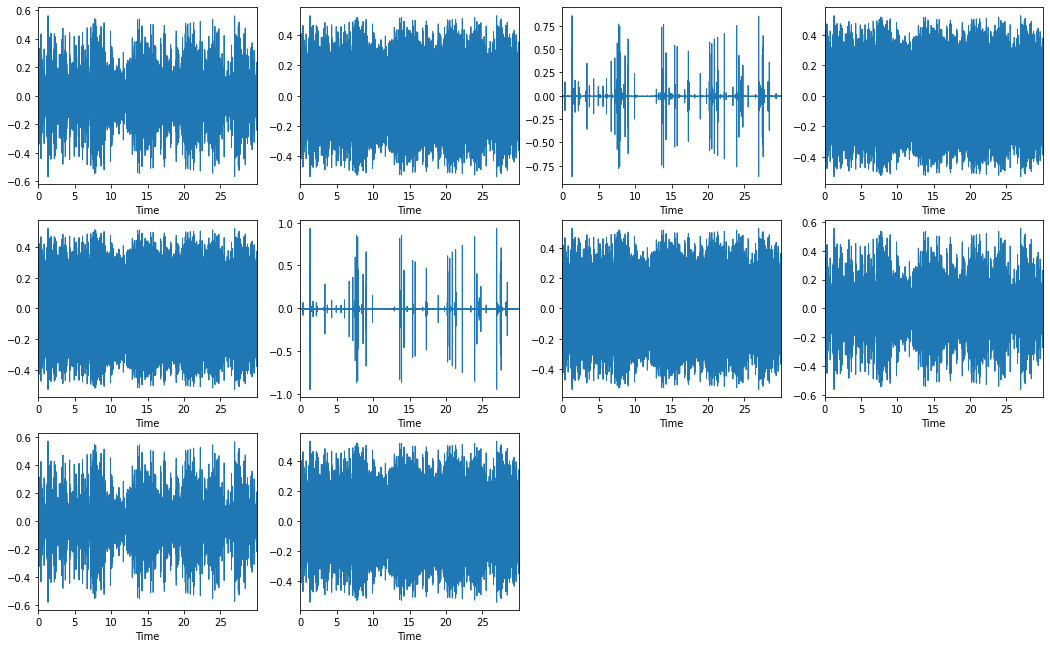

In [ ]:
generate_and_save_images(model, 0, test_sample, 'jazz')

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()
    #Training done
    #ComputeLoss
    loss = tf.keras.metrics.Mean()
    #Test
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    display.clear_output(wait=False)
    elbo = -loss.result()
    #Compute Elbow loss as it is probilistically distributed in a lattice space
    
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch,  test_sample, 'jazz')
    if elbo>=10000: break

# Output Analysis

The diagram below depicts a high-level overview of how things function. In 2D space, sampling does cause problems.
For autoencoders, the regularity of the latent space is a tough issue that depends on the distribution of data in the initial space, the size of the latent space, and the encoder's design. As a result, it is difficult (if not impossible) to guarantee, a priori, that the encoder would arrange the latent space in a sensible and compatible manner with the generating process, which is why we believe there is too much noise and this is our reason for the conclusion.

In the save music[] list the closer the values are the better will be the results , however they are not due to the reasons mentioned above. A 0 indicated no information learn. Ouptut graph is plotted. One can compare the input and ouptut. There is a lot of noise. 

Picture credits: Towards DataScience.com
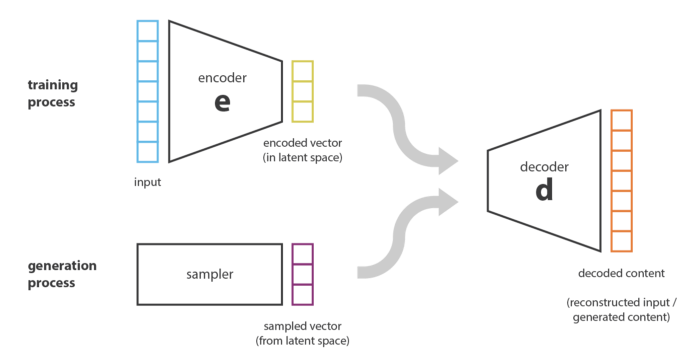

In [ ]:
anim_file_1 = 'jazz_cvae.gif'
with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)




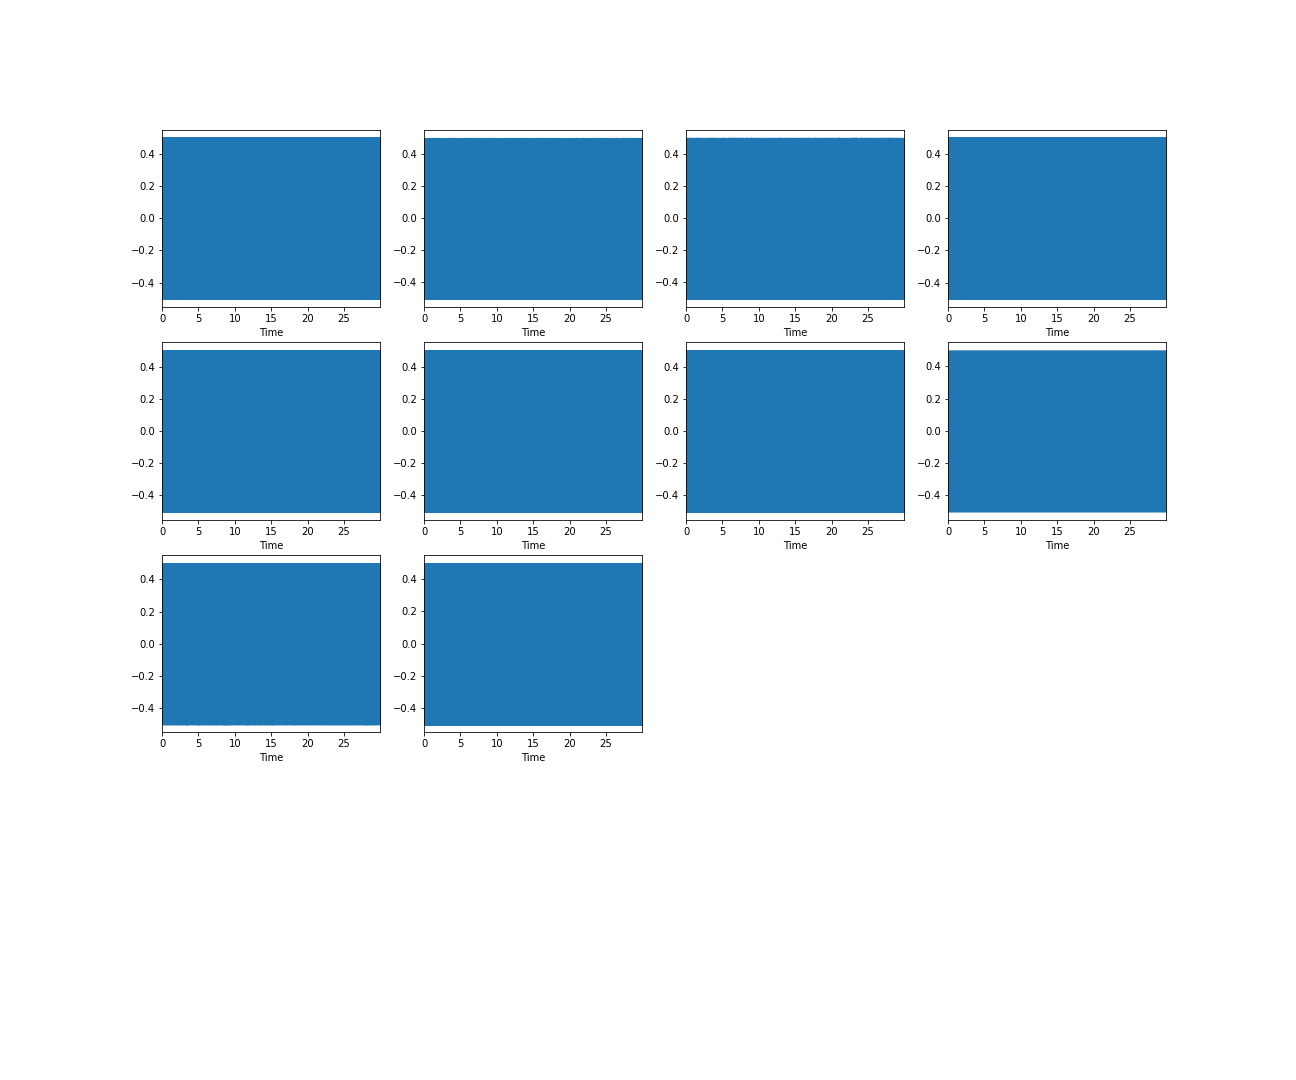

In [ ]:


import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

#output

In [ ]:
save_music = []
for test in test_dataset:
    mean, logvar = model.encode(test)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    for pred in predictions:
        wave = np.asarray(pred)
        save_music.append(wave)

In [ ]:
save_music

[array([[0.09359431, 0.09072623, 0.10901862, ..., 0.11819032, 0.26910505,
         0.1274764 ]], dtype=float32),
 array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         1.7613204e-21, 0.0000000e+00]], dtype=float32),
 array([[0.00023961, 0.00020933, 0.00044471, ..., 0.00062251, 0.02490294,
         0.00085071]], dtype=float32),
 array([[7.9722526e-35, 2.2570650e-35, 2.7250483e-32, ..., 6.5181049e-31,
         1.0382025e-15, 1.2499685e-29]], dtype=float32),
 array([[0.24288258, 0.23963305, 0.25855178, ..., 0.26749492, 0.37707105,
         0.27577367]], dtype=float32),
 array([[0.00015938, 0.00013876, 0.00030532, ..., 0.00043461, 0.02095678,
         0.0006038 ]], dtype=float32),
 array([[0.00076416, 0.0006831 , 0.0013032 , ..., 0.00174022, 0.04095805,
         0.00228158]], dtype=float32),
 array([[0.01349741, 0.01266235, 0.01851696, ..., 0.02192926, 0.1317716 ,
         0.02572414]], dtype=float32),
 array([[0.00155631, 0.00139251, 0.00250217, ..., 0.0032461 

In [ ]:
music1=save_music[0][0] #0
ipd.Audio(music1,rate=3000)

In [ ]:
music1=save_music[4][0] #4
ipd.Audio(music1,rate=3000)
#output

In [ ]:
sample = Test_data[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)
#input
#Clearly there is noise due to the above stated reasons

In [ ]:
music1=save_music[9][0] #11
ipd.Audio(music1,rate=3000)

# Training and testing other Generes.

 Kindly change the name of the gener like [classical, blues, disco etc] and rest should work. 

Epoch: 15, Test set ELBO: 30743.1484375, time elapse for current epoch: 9.430240154266357


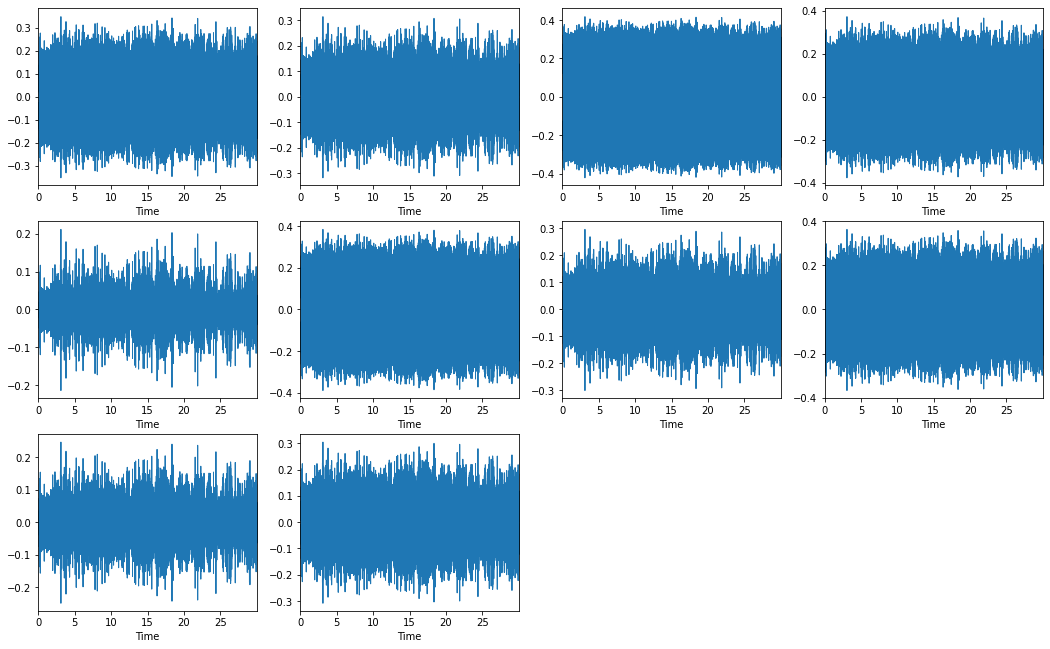

In [ ]:
TrackSet_3, TrackSet_4 = LoadDataset('classical')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_3))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_4))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

generate_and_save_images(model, 0, test_sample, 'classical')

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    display.clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch,
                                                                                   elbo, 
                                                                                   end_time - start_time
                                                                                  ))
    generate_and_save_images(model, 
                             epoch, 
                             test_sample, 
                             'classical')
    

    if elbo>=15000: break


In [ ]:
anim_file_2 = 'classical_cvae.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
    filenames = glob.glob('classical*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

embed.embed_file(anim_file_2)



save_music_classic = []
for test in test_dataset:
    mean, logvar = model.encode(test)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    for pred in predictions:
        wave = np.asarray(pred)
        save_music_classic.append(wave)


In [ ]:
music1=save_music_classic[0][0]
ipd.Audio(music1,rate=3000)


In [ ]:
save_music_classic


[array([[0.02777827, 0.03255463, 0.09627345, ..., 0.12409815, 0.14313778,
         0.03390327]], dtype=float32),
 array([[0.00319999, 0.00415319, 0.02615941, ..., 0.04100171, 0.05275783,
         0.00445303]], dtype=float32),
 array([[0.00043315, 0.00061974, 0.0075793 , ..., 0.01400578, 0.01992157,
         0.00067824]], dtype=float32),
 array([[0.00055492, 0.00078478, 0.00884795, ..., 0.01601097, 0.02250588,
         0.00085652]], dtype=float32),
 array([[0.1390869 , 0.1492823 , 0.24062431, ..., 0.26836646, 0.28526205,
         0.1521163 ]], dtype=float32),
 array([[9.4784191e-06, 1.6190221e-05, 6.8852305e-04, ..., 1.7392933e-03,
         2.9653609e-03, 1.8528241e-05]], dtype=float32),
 array([[0.00325158, 0.00422513, 0.02654275, ..., 0.04118922, 0.05330542,
         0.00452998]], dtype=float32),
 array([[0.05821764, 0.06558558, 0.14748988, ..., 0.17798391, 0.19755036,
         0.06769818]], dtype=float32),
 array([[0.02041167, 0.02430877, 0.08037096, ..., 0.10640624, 0.12475765,
    

In [ ]:

music2=save_music_classic[9][0]
ipd.Audio(music2,rate=3000)